In [67]:
import numpy as np
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')


!wget -O /content/SimHei.ttf https://github.com/StellarCN/scp_zh/raw/master/fonts/SimHei.ttf
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/content/SimHei.ttf')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


--2025-06-28 06:33:16--  https://github.com/StellarCN/scp_zh/raw/master/fonts/SimHei.ttf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/StellarCN/scp_zh/master/fonts/SimHei.ttf [following]
--2025-06-28 06:33:16--  https://raw.githubusercontent.com/StellarCN/scp_zh/master/fonts/SimHei.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9751960 (9.3M) [application/octet-stream]
Saving to: ‘/content/SimHei.ttf’

/content/SimHei.ttf 100%[===================>]   9.30M  --.-KB/s    in 0.1s    

2025-06-28 06:33:16 (92.3 MB/s) - ‘/content/SimHei.ttf’ saved [9751960/9751960]



数据形状: (100, 2)


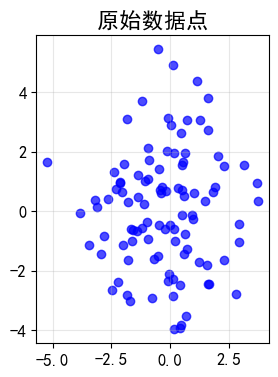

In [68]:
# 创建简单的数据
np.random.seed(42)
torch.manual_seed(42)

n_points = 100
data = np.random.randn(n_points, 2) * 2
print(f"数据形状: {data.shape}")

# 可视化原始数据
plt.figure(figsize=(3,4))
plt.scatter(data[:, 0], data[:, 1], alpha=0.7, c='blue')
plt.title('原始数据点')
plt.grid(True, alpha=0.3)
plt.show()

In [69]:
# SimpleCodebook - K-means实现
class SimpleCodebook:
  """最简单的Codebook实现"""

  def __init__(self, n_codes=8):
      self.n_codes = n_codes  # codebook大小
      self.codebook = None   # 存储code向量
      self.kmeans = None

  def train(self, data):
      """训练codebook"""
      print(f"开始训练 {self.n_codes} 个codes...")

      # 使用K-means聚类
      self.kmeans = KMeans(n_clusters=self.n_codes, random_state=42)
      self.kmeans.fit(data)

      # codebook就是聚类中心
      self.codebook = self.kmeans.cluster_centers_

      print(f"训练完成!")
      print(f"Codebook形状: {self.codebook.shape}")
      return self.codebook

  def encode(self, data):
      """将数据编码为code索引"""
      # 找到每个数据点最近的code
      codes = self.kmeans.predict(data)
      return codes

  def decode(self, codes):
      """从code索引解码回向量"""
      # 根据索引获取对应的codebook向量
      decoded = self.codebook[codes]
      return decoded
# 创建并训练codebook
codebook = SimpleCodebook(n_codes=8)
trained_codes = codebook.train(data)

print(f"\nCodebook内容:")
for i, code in enumerate(trained_codes):
    print(f"Code {i}: [{code[0]:.3f}, {code[1]:.3f}]")

开始训练 8 个codes...
训练完成!
Codebook形状: (8, 2)

Codebook内容:
Code 0: [-5.239, 1.644]
Code 1: [0.216, -2.417]
Code 2: [-0.149, 0.835]
Code 3: [-1.837, -1.381]
Code 4: [2.180, 0.645]
Code 5: [0.478, 3.612]
Code 6: [-2.290, 0.866]
Code 7: [2.026, -1.988]


In [70]:
# 编码：将原始数据转换为code索引
encoded_indices = codebook.encode(data)
print(f"编码结果形状: {encoded_indices.shape}")
print(f"前10个数据点的code索引: {encoded_indices[:10]}")

# 解码：从code索引恢复向量
decoded_data = codebook.decode(encoded_indices)
print(f"解码结果形状: {decoded_data.shape}")

# 计算重建误差
reconstruction_error = np.mean((data - decoded_data) ** 2)
print(f"重建误差 (MSE): {reconstruction_error:.4f}")

编码结果形状: (100,)
前10个数据点的code索引: [4 5 2 4 2 3 1 3 6 3]
解码结果形状: (100, 2)
重建误差 (MSE): 0.5905


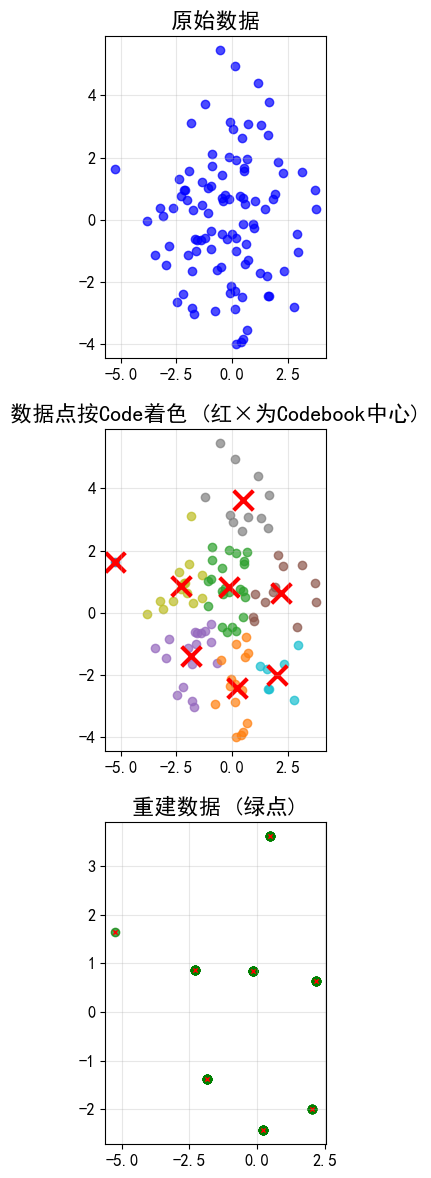

In [76]:
# 可视化结果
fig, axes = plt.subplots(3, 1, figsize=(3, 12))

# 1. 原始数据
axes[0].scatter(data[:, 0], data[:, 1], alpha=0.7, c='blue')
axes[0].set_title('原始数据')
axes[0].grid(True, alpha=0.3)

# 2. Codebook可视化
colors = plt.cm.tab10(np.linspace(0, 1, codebook.n_codes))
for i in range(len(data)):
    code_idx = encoded_indices[i]
    axes[1].scatter(data[i, 0], data[i, 1], c=[colors[code_idx]], alpha=0.7)

# 标记codebook中心
axes[1].scatter(trained_codes[:, 0], trained_codes[:, 1],
               c='red', marker='x', s=200, linewidths=3)
axes[1].set_title('数据点按Code着色 (红×为Codebook中心)')
axes[1].grid(True, alpha=0.3)

# 3. 重建结果
axes[2].scatter(decoded_data[:, 0], decoded_data[:, 1], alpha=0.7, c='green')
axes[2].scatter(trained_codes[:, 0], trained_codes[:, 1],
               c='red', marker='x', s=10, linewidths=1)
axes[2].set_title('重建数据 (绿点)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📊 Code使用统计:
Code 0: 使用 1 次 (1.0%)
Code 1: 使用 15 次 (15.0%)
Code 2: 使用 23 次 (23.0%)
Code 3: 使用 17 次 (17.0%)
Code 4: 使用 12 次 (12.0%)
Code 5: 使用 11 次 (11.0%)
Code 6: 使用 14 次 (14.0%)
Code 7: 使用 7 次 (7.0%)


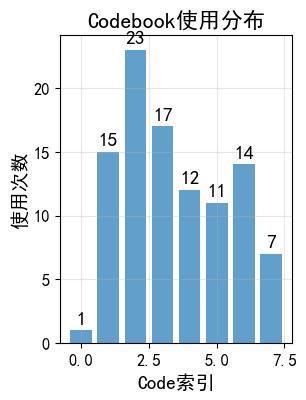

In [72]:
# 分析Codebook使用情况
from collections import Counter

# 统计每个code的使用次数
code_usage = Counter(encoded_indices)
print("📊 Code使用统计:")
for code_idx in range(codebook.n_codes):
    count = code_usage.get(code_idx, 0)
    percentage = count / len(data) * 100
    print(f"Code {code_idx}: 使用 {count} 次 ({percentage:.1f}%)")

# 可视化使用分布
plt.figure(figsize=(3, 4))
codes_list = list(range(codebook.n_codes))
usage_counts = [code_usage.get(i, 0) for i in codes_list]

plt.bar(codes_list, usage_counts, alpha=0.7)
plt.title('Codebook使用分布')
plt.xlabel('Code索引')
plt.ylabel('使用次数')
plt.grid(True, alpha=0.3)

# 添加数值标签
for i, count in enumerate(usage_counts):
    plt.text(i, count + 0.5, str(count), ha='center')

plt.show()

开始训练 4 个codes...
训练完成!
Codebook形状: (4, 2)
开始训练 8 个codes...
训练完成!
Codebook形状: (8, 2)
开始训练 16 个codes...
训练完成!
Codebook形状: (16, 2)
开始训练 32 个codes...
训练完成!
Codebook形状: (32, 2)


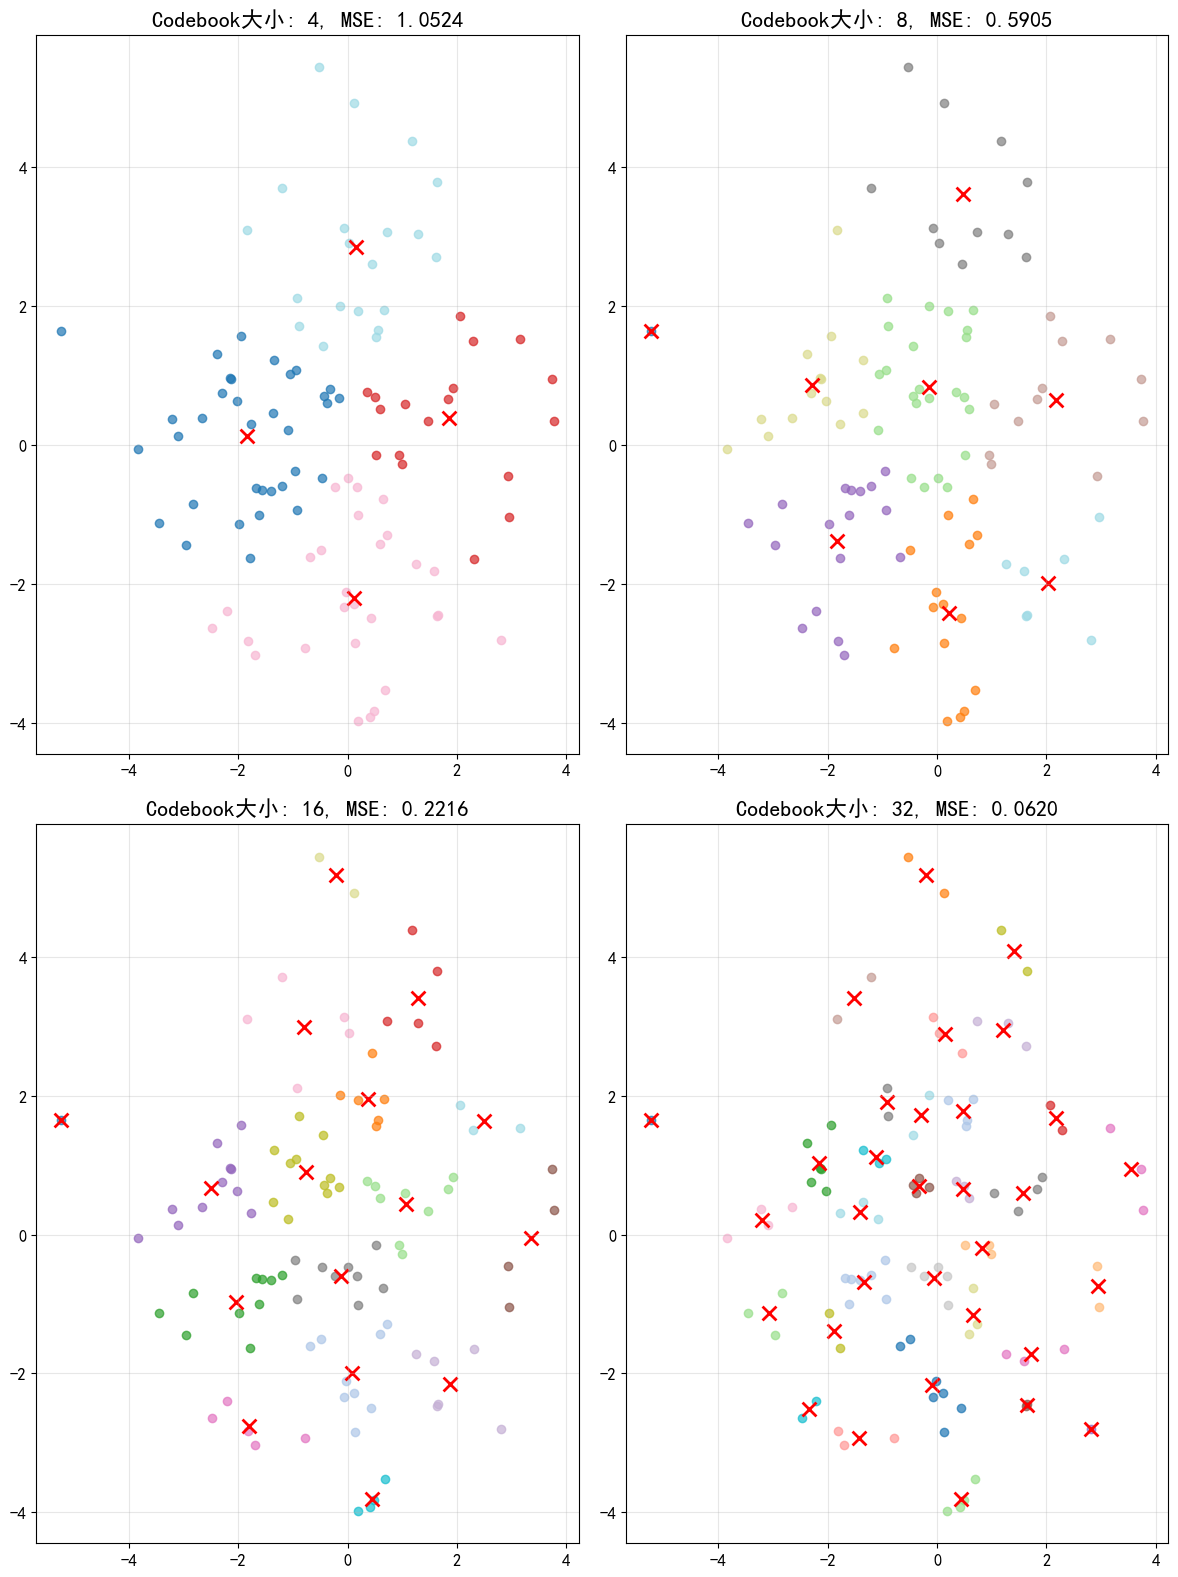

📈 不同Codebook大小的性能:
大小	重建误差(MSE)
--------------------
4	1.052381
8	0.590487
16	0.221637
32	0.061970


In [73]:
def experiment_with_different_codebook_sizes():
    """实验不同的codebook大小"""

    sizes = [4, 8, 16, 32]
    results = []

    fig, axes = plt.subplots(2, 2, figsize=(12, 16))
    axes = axes.flatten()

    for i, size in enumerate(sizes):
        # 训练不同大小的codebook
        cb = SimpleCodebook(n_codes=size)
        cb.train(data)

        # 编码解码
        codes = cb.encode(data)
        decoded = cb.decode(codes)

        # 计算误差
        mse = np.mean((data - decoded) ** 2)
        results.append((size, mse))

        # 可视化
        colors = plt.cm.tab20(np.linspace(0, 1, size))
        for j in range(len(data)):
            code_idx = codes[j]
            axes[i].scatter(data[j, 0], data[j, 1], c=[colors[code_idx]], alpha=0.7)

        axes[i].scatter(cb.codebook[:, 0], cb.codebook[:, 1],
                       c='red', marker='x', s=100, linewidths=2)
        axes[i].set_title(f'Codebook大小: {size}, MSE: {mse:.4f}')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 显示结果表格
    print("📈 不同Codebook大小的性能:")
    print("大小\t重建误差(MSE)")
    print("-" * 20)
    for size, mse in results:
        print(f"{size}\t{mse:.6f}")

# 运行实验
experiment_with_different_codebook_sizes()
